<a href="https://colab.research.google.com/github/saivenkat2309/ML_A1/blob/main/ML_AS_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv("/content/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [62]:
df['furnishingstatus'].value_counts().unique
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [63]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False)
df = df.drop('furnishingstatus_semi-furnished', axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,1,0
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,1,0
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,0,0
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,1,0
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,1,0


In [64]:
binary_columns = df.select_dtypes(include=['object']).columns
binary_columns


Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')

In [65]:
df[binary_columns] = df[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [66]:

df.shape

(545, 14)

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()


In [69]:
X = df.drop('price', axis = 1)
y = df[['price']]

In [70]:

X = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns, index=X.index).values
y = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index).values


In [71]:
train_X, val_X, train_Y, val_Y = train_test_split(X, y, test_size=0.3, random_state=43)
X_train = torch.tensor(train_X)
y_train =  torch.tensor(train_Y)
X_val =  torch.tensor(val_X)
y_val =  torch.tensor(val_Y)

In [72]:
training_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [73]:
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=31)

In [74]:
def model_train(model, criterion, optimizer, epochs, train_loader, X_val, y_val):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
              loss_val.append(val_loss)
              loss_train.append(loss)
    return loss_train, loss_val


In [75]:
# Model 1
model1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 1)
).to(torch.float64)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_val, y_val)

Epoch 0/5000, Training Loss: 0.057680704183373406, Validation Loss: 0.04967111995996672
Epoch 500/5000, Training Loss: 0.007120371379912978, Validation Loss: 0.011311052148841544
Epoch 1000/5000, Training Loss: 0.005584059098121514, Validation Loss: 0.011222769465113655
Epoch 1500/5000, Training Loss: 0.0037447472548059824, Validation Loss: 0.011233484711964972
Epoch 2000/5000, Training Loss: 0.004800658525189319, Validation Loss: 0.011209587142686644
Epoch 2500/5000, Training Loss: 0.003186652445997331, Validation Loss: 0.011221522527186263
Epoch 3000/5000, Training Loss: 0.006711991579416309, Validation Loss: 0.011214887721283871
Epoch 3500/5000, Training Loss: 0.006170067981412402, Validation Loss: 0.01124823674751305
Epoch 4000/5000, Training Loss: 0.007110775268865257, Validation Loss: 0.011276317873148664
Epoch 4500/5000, Training Loss: 0.006726883176087445, Validation Loss: 0.011292896439954387
Epoch 5000/5000, Training Loss: 0.008707500598182859, Validation Loss: 0.011338687912

In [76]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [77]:

total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')


Total number of trainable parameters  481 



In [78]:
epochs = range(0, 5001, 500)
epochs

range(0, 5001, 500)

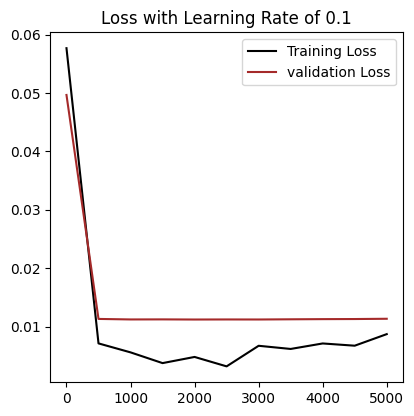

In [79]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='black', label = 'Training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='brown', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.1')
plt.legend()

plt.show()

In [89]:
model2 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 64),
    nn.Tanh(),
    nn.Linear(64, 16),
    nn.Tanh(),
    nn.Linear(16, 1)
).to(torch.float64)
criterion = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)
train_loss_2, val_loss_2 = model_train(model2, nn.MSELoss(), optimizer2, 5000, train_loader, X_val, y_val)

Epoch 0/5000, Training Loss: 0.011484832848774221, Validation Loss: 0.025011092723478952
Epoch 500/5000, Training Loss: 0.010309923272479413, Validation Loss: 0.01106716174571905
Epoch 1000/5000, Training Loss: 0.004125465096214316, Validation Loss: 0.011196762805553364
Epoch 1500/5000, Training Loss: 0.00694809367499147, Validation Loss: 0.011259099217296373
Epoch 2000/5000, Training Loss: 0.007048986564300657, Validation Loss: 0.013187245224686152
Epoch 2500/5000, Training Loss: 0.0033302987392781853, Validation Loss: 0.011496163356856366
Epoch 3000/5000, Training Loss: 0.005436001816124161, Validation Loss: 0.012494567969041727
Epoch 3500/5000, Training Loss: 0.0053198104044667295, Validation Loss: 0.011850653580106415
Epoch 4000/5000, Training Loss: 0.00624357124620236, Validation Loss: 0.012247738474839863
Epoch 4500/5000, Training Loss: 0.003199953439173035, Validation Loss: 0.012430813234675412
Epoch 5000/5000, Training Loss: 0.005846890615094434, Validation Loss: 0.012558053657

In [90]:
for name, param in model2.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([64, 32])
Parameter name: 2.bias, Shape: torch.Size([64])
Parameter name: 4.weight, Shape: torch.Size([16, 64])
Parameter name: 4.bias, Shape: torch.Size([16])
Parameter name: 6.weight, Shape: torch.Size([1, 16])
Parameter name: 6.bias, Shape: torch.Size([1])


In [91]:
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  3617 



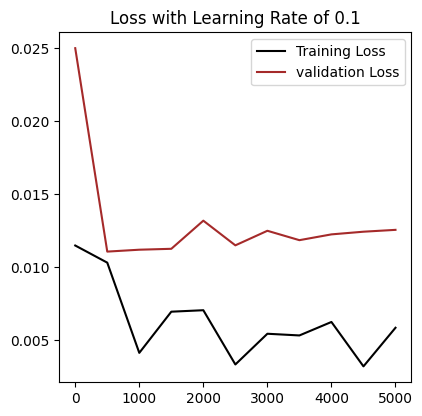

In [92]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss_2]), color='black', label = 'Training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss_2]), color='brown', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.1')
plt.legend()

plt.show()